# How to create a cumulative PL calculation

In this notebook, we'll illustrate cumulative PL calculation. In our example, the [rate-of-return](https://www.investopedia.com/terms/r/rateofreturn.asp) will accumulate over time according to the following formulae:

$$Cumulative\ RoC = \prod_{start\_date}^{end\_date}\left ( 1+RoR \right )-1$$

This formula will recalculate automatically for every scope of data we'll add into the view

![Interactive RoR BI](interactive-ror.gif)

The example can be adjusted, for example, instead of product you can use summation over time, and the daily measure can be any profit-and-loss metric that you could think of.

[In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/master/cumulative-pnl/notebooks/cumulative-pnl/main.ipynb).

In [1]:
import atoti as tt

In [2]:
session = tt.Session(user_content_storage= "./content")
positions = session.read_csv(
    "s3://data.atoti.io/notebooks/cumulative-pnl/positions.csv",
    table_name="positions",
    keys=[
        "AsOfDate",
        "Portfolio ID",
        "Real Asset ID",
        "Instrument ID",
        "Portfolio Type",
    ],
)


positions.head()

Size  \
AsOfDate   Portfolio ID Real Asset ID Instrument ID      Portfolio Type         
2020-01-31 a_02_2_b     ra_02_2       US94974BEV80_ptz6d Active          4592   
2021-02-04 a_03_03_11_a ra_03_03_11   CH0323735669_42xl6 Active          4845   
           ra_03_05_6   ra_03_05_6    KYG211311009_f1j1m Real Asset      1931   
2020-01-31 bm_02_03_6_a ra_02_03_6    KR7005931001_ophtt Benchmark       6309   
           a_02_05_5_a  ra_02_05_5    CH0131078435_hwkqu Active         -5212   

                                                                         Investment  \
AsOfDate   Portfolio ID Real Asset ID Instrument ID      Portfolio Type               
2020-01-31 a_02_2_b     ra_02_2       US94974BEV80_ptz6d Active               327.5   
2021-02-04 a_03_03_11_a ra_03_03_11   CH0323735669_42xl6 Active              -442.3   
           ra_03_05_6   ra_03_05_6    KYG211311009_f1j1m Real Asset           175.0   
2020-01-31 bm_02_03_6_a ra_02_03_6    KR7005931001_ophtt Benchmark             30.2   
           a_02_05_5_a  ra_02_05_5    CH0131078435_hwkqu Active              -169.8   

                                                                         Profit-and-loss  
AsOfDate   Portfolio ID Real Asset ID Instrument ID      Portfolio Type                   
2020-01-31 a_02_2_b     ra_02_2       US94974BEV80_ptz6d Active                    2.798  
2021-02-04 a_03_03_11_a ra_03_03_11   CH0323735669_42xl6 Active                    2.864  
           ra_03_05_6   ra_03_05_6    KYG211311009_f1j1m Real Asset                1.707  
2020-01-31 bm_02_03_6_a ra_02_03_6    KR7005931001_ophtt Benchmark                 0.126  
           a_02_05_5_a  ra_02_05_5    CH0131078435_hwkqu Active                    2.181

In [3]:
instrument_attributes = session.read_csv(
    "s3://data.atoti.io/notebooks/cumulative-pnl/instrument_attributes.csv",
    table_name="instrument_attributes",
    keys=["Instrument ID"],
)


instrument_attributes.head()

,Instrument Name,Instrument Currency,Instrument Type,Issuer,Country,Coupon,Yield,Maturity Date,Issue Date
Instrument ID,,,,,,,,,
BMG2519Y1084_c7isk,Credicorp LtdShs,USD,Shares,N/A,Peru,NaN,NaN,N/A,N/A
BRB3SAACNOR6_2mteq,B3 SA - Brasil Bolsa Balcao,BRL,Shares,N/A,Brazil,NaN,NaN,N/A,N/A
BRDTEXACNOR3_pnhhe,Duratex SA,BRL,Shares,N/A,Brazil,NaN,NaN,N/A,N/A
BRESTCACNOR5_ltfex,ESTACIO PARTICIPACOE,BRL,Shares,N/A,Brazil,NaN,NaN,N/A,N/A
BRKROTACNOR9_5zsat,Kroton Educacional SA Conv Shs Voting,BRL,Shares,N/A,Brazil,NaN,NaN,N/A,N/A


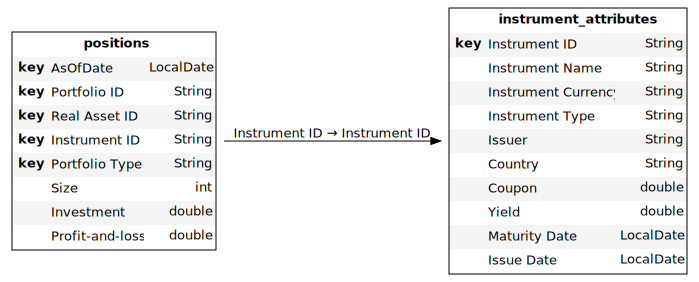

In [4]:
cube = session.create_cube(positions, mode="auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures

positions.join(instrument_attributes)
cube.schema

In [5]:
m["Daily ROR"] = m["Profit-and-loss.SUM"] / m["Investment.SUM"]
m["Daily ROR"].formatter = "DOUBLE[#,##0.000%]"

m["Daily ROR + 1"] = m["Daily ROR"] + 1
m["Daily ROR + 1"].formatter = "DOUBLE[#,##0.0000]"

In [6]:
cube.create_date_hierarchy(
    "Calendar",
    column=positions["AsOfDate"],
    levels={"Year": "Y", "Month": "MMMM", "Day": "d"},
)
h["Calendar"].slicing = True

In [7]:
cube.levels["Month"].order = tt.PartialOrder(first_elements=[
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
)

In [8]:
m["Since Inception ROR"] = (
    tt.agg.prod(
        m["Daily ROR + 1"],
        scope=tt.scope.cumulative(l["Day"]),
    )
    - 1
)
m["Since Inception ROR"].formatter = "DOUBLE[#,##0.000%]"

m["MtD ROR"] = tt.where(
    l["Day"] != None,
    (
        tt.agg.prod(
            m["Daily ROR + 1"],
            scope=tt.scope.cumulative(l["Day"], partitioning=l["Month"]),
        )
        - 1
    ),
)
m["MtD ROR"].formatter = "DOUBLE[#,##0.000%]"

m["YtD ROR"] = tt.where(
    l["Day"] != None,
    (
        tt.agg.prod(
            m["Daily ROR + 1"],
            scope=tt.scope.cumulative(l["Day"], partitioning=l["Year"]),
        )
        - 1
    ),
)
m["YtD ROR"].formatter = "DOUBLE[#,##0.000%]"

In [9]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.